In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysa.emd as emddev
import pysa.eemd as eemddev
import pysa.visualization as plotter
import pysa.utils as utils
from scipy import signal
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams.update({'font.size': 14})

In [26]:
def notch_filter(input_signal):
    fs = 250.0  # Sample frequency (Hz)
    f0 = 50.0  # Frequency to be removed from signal (Hz)
    Q = 30.0  # Quality factor
    w0 = f0/(fs/2)  # Normalized Frequency
    # Design notch filter
    b, a = signal.iirnotch(w0, Q)

    return signal.filtfilt(b, a, input_signal)

In [4]:
def IMF_filter(signal):
    max_modes = 15
    ensembles = 100
    ensembles_per_process = 10
    max_siftings = 200
    end_time = 10
    sample_freq = 250

    max_data = max(signal)
    min_data = min(signal)
    
    imfs = emddev.emd(signal, min_data, max_data, max_modes, max_siftings)
    
    imf1 = utils.reverse_normalization(imfs[0], min_data, max_data, len(signal))
    imf2 = utils.reverse_normalization(imfs[1], min_data, max_data, len(signal))
    residue = utils.reverse_normalization(imfs[-1], min_data, max_data, len(signal))
    return signal - imf1 - imf2

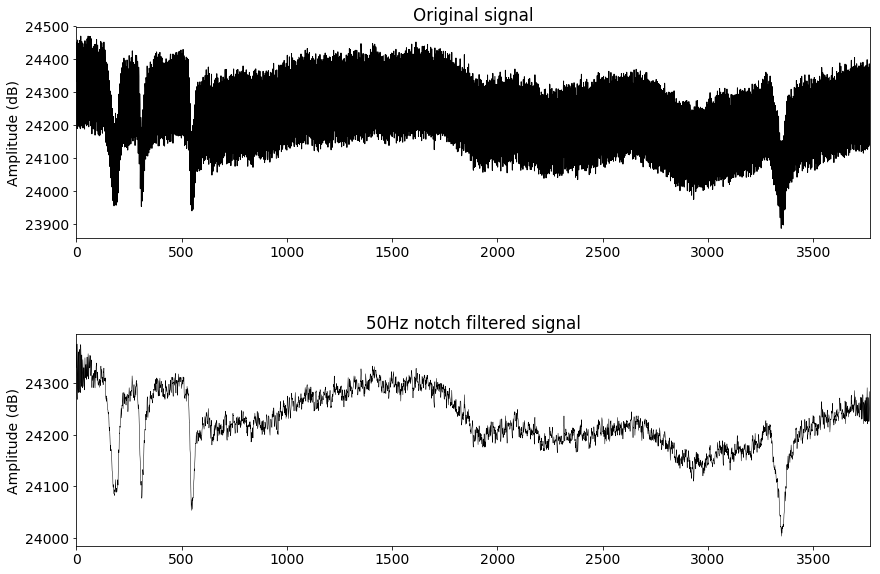

In [27]:
# Electrical noise filter plot
path = 'Data/Joachim/'
files = []
count = 0
for i in os.listdir(path):
    files.append(i)

df = pd.read_csv(os.path.join(path, files[1]), index_col=0)
data = df.as_matrix()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
fig.tight_layout(h_pad=5)

line1 = ax[0].plot(data[:,1], color='black')
plt.setp(line1, linewidth=1)
ax[0].set_title("Original signal")
ax[0].set_ylabel("Amplitude (dB)")
ax[0].set_xlim([0, len(data[:,1])])
#ax[0].spines['top'].set_visible(False)
#ax[0].spines['right'].set_visible(False)
ax[0].grid(False)

line2 = ax[1].plot(notch_filter(data[:,1]), color='black')
plt.setp(line2, linewidth=0.5)
ax[1].set_title("50Hz notch filtered signal")
ax[1].set_ylabel("Amplitude (dB)")
ax[1].set_xlim([0, len(data[:,1])])
#ax[1].spines['top'].set_visible(False)
#ax[1].spines['right'].set_visible(False)
ax[1].grid(False)

fig.savefig("plots/electrical_noise_notch.eps", format="eps")

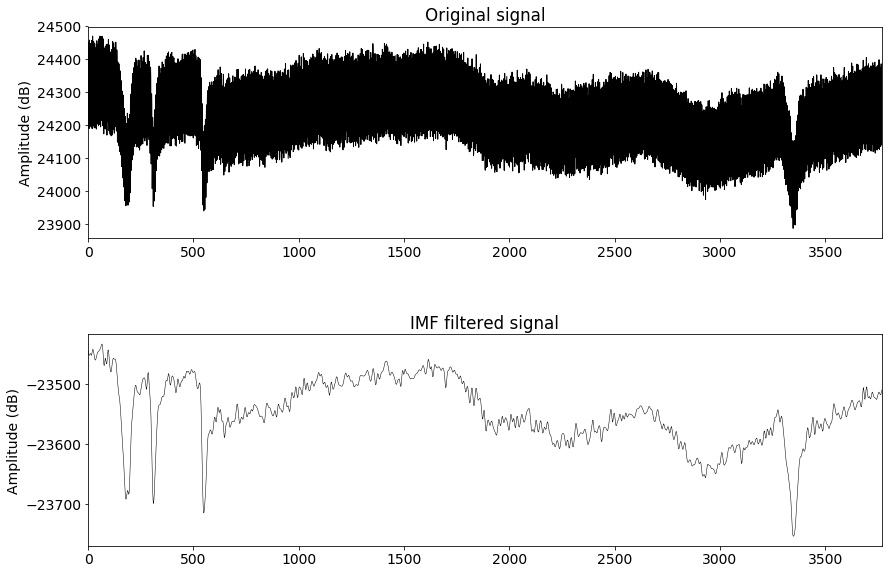

In [6]:
# IMF filter plot
path = 'Data/Joachim/'
files = []
count = 0
for i in os.listdir(path):
    files.append(i)

df = pd.read_csv(os.path.join(path, files[1]), index_col=0)
data = df.as_matrix()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
fig.tight_layout(h_pad=5)

line1 = ax[0].plot(data[:,1], color='black')
plt.setp(line1, linewidth=1)
ax[0].set_title("Original signal")
ax[0].set_ylabel("Amplitude (dB)")
ax[0].set_xlim([0, len(data[:,1])])
#ax[0].spines['top'].set_visible(False)
#ax[0].spines['right'].set_visible(False)
ax[0].grid(False)

line2 = ax[1].plot(IMF_filter(data[:,1]), color='black')
plt.setp(line2, linewidth=0.5)
ax[1].set_title("IMF filtered signal")
ax[1].set_ylabel("Amplitude (dB)")
ax[1].set_xlim([0, len(data[:,1])])
#ax[1].spines['top'].set_visible(False)
#ax[1].spines['right'].set_visible(False)
ax[1].grid(False)

fig.savefig("plots/electrical_noise_IMF.eps", format="eps")

3769